# Binary Classification of Fake or Real News


Using kaggle's dataset of "Fake and real news dataset", taken from ISOT News Dataset (https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php), we are trying to classify the authenticity of news recorded since 2015 to 2018. 

This dataset was scraped through reuters.com (real news) and politifact.com (fake news) by University of Victoria.

We are using various methods of tokenization and machine learning algorithms to show which algorithms can give the most satisfying result to classify fake or real news.

1. Data preparation
2. Visualization
3. Creating models
- Using tf-idf
    * SVM
    * Decision Tree
    * Random Forest
    * XGBoost
- Using GloVe
    * LSTM



The division of responsibility is as follow,

* Yifan is responsible for all the data preparation and visualization,

* Yilang is responsible for creating model using TF-IDF

* Kaicheng is responsible for creating model using GloVe, and LSTM


Although each of our member has their own responsibilty, we often exchange suggestion and always ask one another if there is any confusion.

``Importing packages``

In [1]:
# !pip install nltk
# !pip install plotly
# !pip install wordcloud
# !pip install tensorflow
# !pip install xgboost
# !pip install datasets
# !pip install transformers[torch]


In [2]:
import os
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score,roc_curve,auc

ModuleNotFoundError: No module named 'seaborn'

## Data Preparation

This data is prepared by Yifan while considering the usage of the data on every model/method we are preparing

``Importing our datasets``

In [ ]:
path = 'dataset'

fake = pd.read_csv(os.path.join(path, 'Fake.csv'))
real = pd.read_csv(os.path.join(path, 'True.csv'))

In [ ]:
real.head()

We noticed that the first 5 texts of real news have "(Reuters)" and a city name in front of it.

In [ ]:
fake.head()

However, this is not the case for fake news. Let's find out how many of real news contain "(Reuters)" tag in it.

In [ ]:
print("Real news with 'Reuters': " + str(real.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(real.shape[0]) + ", " + str(real.text.str.contains("\(Reuters\) -").mean()*100)+"%")
print("Fake news with 'Reuters': " + str(fake.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(fake.shape[0]) + ", " + str(fake.text.str.contains("\(Reuters\) -").mean()*100)+"%")

This can be bad for our machine learning model, as our model can be biased towards the "(Reuters)" word --> if it contains "(Reuters)", predict real news.

Let's see what happens if we predict False (real news) when the text contains "(Reuters)"


``Combining real and fake news data to 1 DataFrame``

In [ ]:
fake_with_label = fake.assign(is_fake = 1)
real_with_label = real.assign(is_fake = 0)

data = pd.concat([real_with_label,fake_with_label],axis=0,ignore_index=True) 

In [ ]:
no_reuters = ~data.text.str.contains("\(Reuters\) - ")

In [ ]:
cf_matrix = confusion_matrix(no_reuters, data['is_fake'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = "d")

print("Accuracy score: "+str(accuracy_score(no_reuters, data['is_fake'])*100) + "%")
print("\nConfusion matrix: ")

We can obtain 99.6% accuracy with only that condition. Therefore, we need to delete "(Reuters)" if it appears in the first 5 words of the text, delete it and the city name preceding it.

To do this, we are using regex, which is '.\*\\(Reuters\) - ', meaning everything before and the word '(Reuters) - '. The function below deletes the words according to the regex in data['text'].

``Removing the words``

In [ ]:
# data = data.replace(to_replace = r'.*\(Reuters\) - ', value = '', regex = True)

# Exported to save time running the program
# data.to_csv(os.path.join(path,"data.csv"))

# Load exported file
data = pd.read_csv(os.path.join(path,"data.csv"))


data.head()

Great! We successfully removed a huge exploit to our model. 

Another problem that usually happens is empty/null values in our dataset. Let's check if there are any.

In [ ]:
data = data.replace(to_replace = r'U.S.', value = 'U.S.A.', regex = True)
data.head()

``Checking empty values``

In [ ]:
data.isnull().sum()

Seems like there are no empty values in our dataset.

Another problem that usually occurs is duplicates in our dataset. Let's check if there are any.

``Checking duplicates``

In [ ]:
duplicates_text = data[data.duplicated(subset = ['text'])]
duplicates_title = data[data.duplicated(subset = ['title'])]

print("Duplicates in text: " + str(duplicates_text.shape[0]) + "/" + str(data.shape[0]))
print("Duplicates in title: " + str(duplicates_title.shape[0]) + "/" + str(data.shape[0]))

There are quite a lot of duplicates in our dataset. After splitting into train and test set, these duplicates in our train set can leak to our test set. Hence, we need to remove them.

``Removing duplicates``

In [ ]:
data = data.drop_duplicates(subset = ['text'])
data = data.drop_duplicates(subset = ['title'])

data.shape

We successfully removed the duplicates in our dataset. Now we need to drop the subject and date column since we only want to classify the news based on the title and the article. We are still keeping them in separate variable for visualization.

``Dropping columns``

In [ ]:
data_cleaned = data.drop(columns = ['subject', 'date'])
data_cleaned["article"] = data_cleaned["title"] + data_cleaned["text"]
data_cleaned.to_csv(path+"data_cleaned.csv", index = False)

full_data = data

data_cleaned = pd.read_csv(path+"data_cleaned.csv")

In [ ]:
data_cleaned.head()

This data is now ready to be visualized. We also need to split our data for training and testing.

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data_cleaned['article']=data_cleaned['article'].apply(lambda x:review_cleaning(x))
data_cleaned.head()

In [ ]:
nltk.download('stopwords')

stop = stopwords.words('english')
data_cleaned['article'] = data_cleaned['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data_cleaned.head()

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

lemma = WordNetLemmatizer()
lem = lambda x: ' '.join(list(map(lemma.lemmatize, x.split())))
data_cleaned['article'] = data_cleaned['article'].apply(lem)

data_cleaned.head()

In [ ]:
data_cleaned = pd.read_csv(os.path.join(path, 'data_cleaned.csv'))

data_cleaned = data_cleaned[~data_cleaned.article.isnull()]
data_cleaned.shape

data_cleaned.to_csv(os.path.join(path, 'data_cleaned.csv'), index = False)

data_cleaned.shape

Our data is now cleaned.

``Splitting data``

We are splitting our data to 80% training and 20% test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

## Visualization

Now we need to visualize our data. We will start by the count of fake and real news in our dataset.

In [ ]:
bar_type_df = pd.DataFrame({'Type': ['Real', 'Fake'], 'Count': [full_data[full_data['is_fake'] == 0].count()[0], full_data[full_data['is_fake'] == 1].count()[0]]}) 

fig = px.bar(bar_type_df, x = "Type", y = "Count", color = "Count")
fig.show()

Ratio of "Real":"Fake" is 20821:17449, which is around 1.19:1. Pretty good for our dataset as it is not too imbalanced.

Counting our dataset by its subjects

In [ ]:
bar_subject_df=full_data.groupby(['subject', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(bar_subject_df,x='subject',y='Counts',color='is_fake',title='Count of News Articles by Subject')
fig.show()

Now, we want to see when our news articles are posted.

In [ ]:
line_date_df=full_data.groupby(['date', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')

line_date_df = (line_date_df[line_date_df.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Sep|Oct|Nov|Dec")])
line_date_df['date'] = pd.to_datetime(line_date_df.date)

line_date_df = line_date_df.sort_values(by='date')

line_date_df.head()

In [ ]:
fig = px.line(line_date_df, x = "date", y = "Counts", color = "is_fake")
fig.show()

We want to see the wordcloud of our fake and real news.

In [ ]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

``Real News WordCloud``

In [ ]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 0].article.values)

``Fake News WordCloud`` 

In [ ]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 1].article.values)

Now, we will visualize our article's length to determine the max length, especially for GloVe

In [ ]:
word_count = data_cleaned
word_count['word count'] = data_cleaned['article'].str.split().str.len()

fig = px.histogram(word_count, x="word count")
fig.show()

As we can see from the histogram, 250 as our word length is sufficient without sacrificing our model's robustness.

## Creating models

``Baseline Model``

In [ ]:
print(20821/38265*100)

Since there sre 54.41% of real news, we can set our baseline model to 54.41%. If our model could pass this baseline model, it means that it has successfully learned to classify our dataset.

### TF-IDF

``Importing the required library``

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['article'], data_cleaned['is_fake'], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [ ]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    return float(accuracy_score(y_test, y_pred))
    
def final_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,5)))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18})
    plt.show()
    print("Classification Report: \n", classification_report(y_test, y_pred))

#### SVM

In [ ]:
accuracy = 0.0
tmp_accuracy = 0.0
best_c=0
c_list= [ 0.1,0.5,0.9, 1.0, 1.1]


for c in c_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), LinearSVC(C =c, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy = tmp_accuracy     
    best_c=c

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of C possibilities, the fittest C parameter for this data is C =", best_c)
final_prediction(TfidfVectorizer(), LinearSVC(C =best_c), X_train, X_test, y_train, y_test)


#### Decision Tree

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_depth=0
depth_list= [10,30,50,100]


for depth in depth_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_depth=depth

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of depth possibilities, the fittest depth parameter for this data is depth =", best_depth)
final_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### Random Forest

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_trees= [100,200,300]


for n_tree in n_trees :
  tmp_accuracy = get_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is = ", best_n_tree)
final_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = best_n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### XGBoost

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_tree_list= [100, 200, 300, 500]


for n_tree in n_tree_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = n_tree, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is =", n_tree)
final_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = best_n_tree, random_state = 100), X_train, X_test, y_train, y_test)

Although in each of the model it seems that we only try on 4 values on the parameters, we have actually tried more than that, however, in order to save the running time we only put 4 different values on each parameters to show the contrast and that twitching the values will give us a better result.

### GloVe

An unsupervised learning algorithm used to obtain vector representation of words

``Importing the required library``

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

#### Tokenize + Padding

Tokenizer finds the frequency of each unique word and sort them based on their frequency. Then, it will assign an integer value (starting from 1) to each word from the top.

In [ ]:
xtrain_values = X_train['article'].values
xtest_values = X_test['article'].values

In [ ]:
max_len = 250

In [ ]:
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)

# Fit tokenizer on our training data set to create the word indices
tokenizer.fit_on_texts(xtrain_values)

# Using word index from fit_on_texts step, we transform both train & test data set
X_train_seq = tokenizer.texts_to_sequences(xtrain_values)
X_test_seq = tokenizer.texts_to_sequences(xtest_values)

# Add padding to the sequence
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen = max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen = max_len)
word_index = tokenizer.word_index


In [ ]:
print("Text example:", xtrain_values[0])
print("Sequence of indices (before add padding): ", X_train_seq[0])
print("Sequence of indices (after add padding): ", X_train_pad[0])

#### Word Embedding using pre-trained GloVe vectors

Represent words with similar meaning to have similar representation

(GloVe pre-trained word vectors via: https://nlp.stanford.edu/projects/glove/)


Load the GloVe vectors

In [ ]:
glovetxt = os.path.join(path, 'glove.6B.100d.txt')

In [ ]:
embedding_vectors = {};

with open(glovetxt) as f:
    for line in f:
        values = line.split();
        word = values[0];
        weights = np.asarray(values[1:], dtype='float32');
        embedding_vectors[word] = weights;


In [ ]:
print("Size of vocabulary in GloVe", len(embedding_vectors))

**Embedding matrix with the GloVe vectors**

Embedding matrix with a shape of (vocab length, embedding dimension)

Each row of the matrix belongs to one word in the vocabulary and contains the weight of embedding vectors of the word

In [ ]:
embedding_dim = 100   # size of the vector space in which words will be embedded
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_len, embedding_dim))

In [ ]:
oov_count = 0
oov_words = []

for word, i in word_index.items():
  if i<vocab_len:
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    # If a word in word_index is not found in the embedding_vectors from GloVe, we put it in oov_words and its weight remains 0
    else:
      oov_count+=1
      oov_words.append(word)

In [ ]:
print("Some Out of Vocabulary words: ", oov_words[0:10])

In [ ]:
print(f"{oov_count} out of {vocab_len} words are OOV")

#### Modeling

##### **Model Architecture**

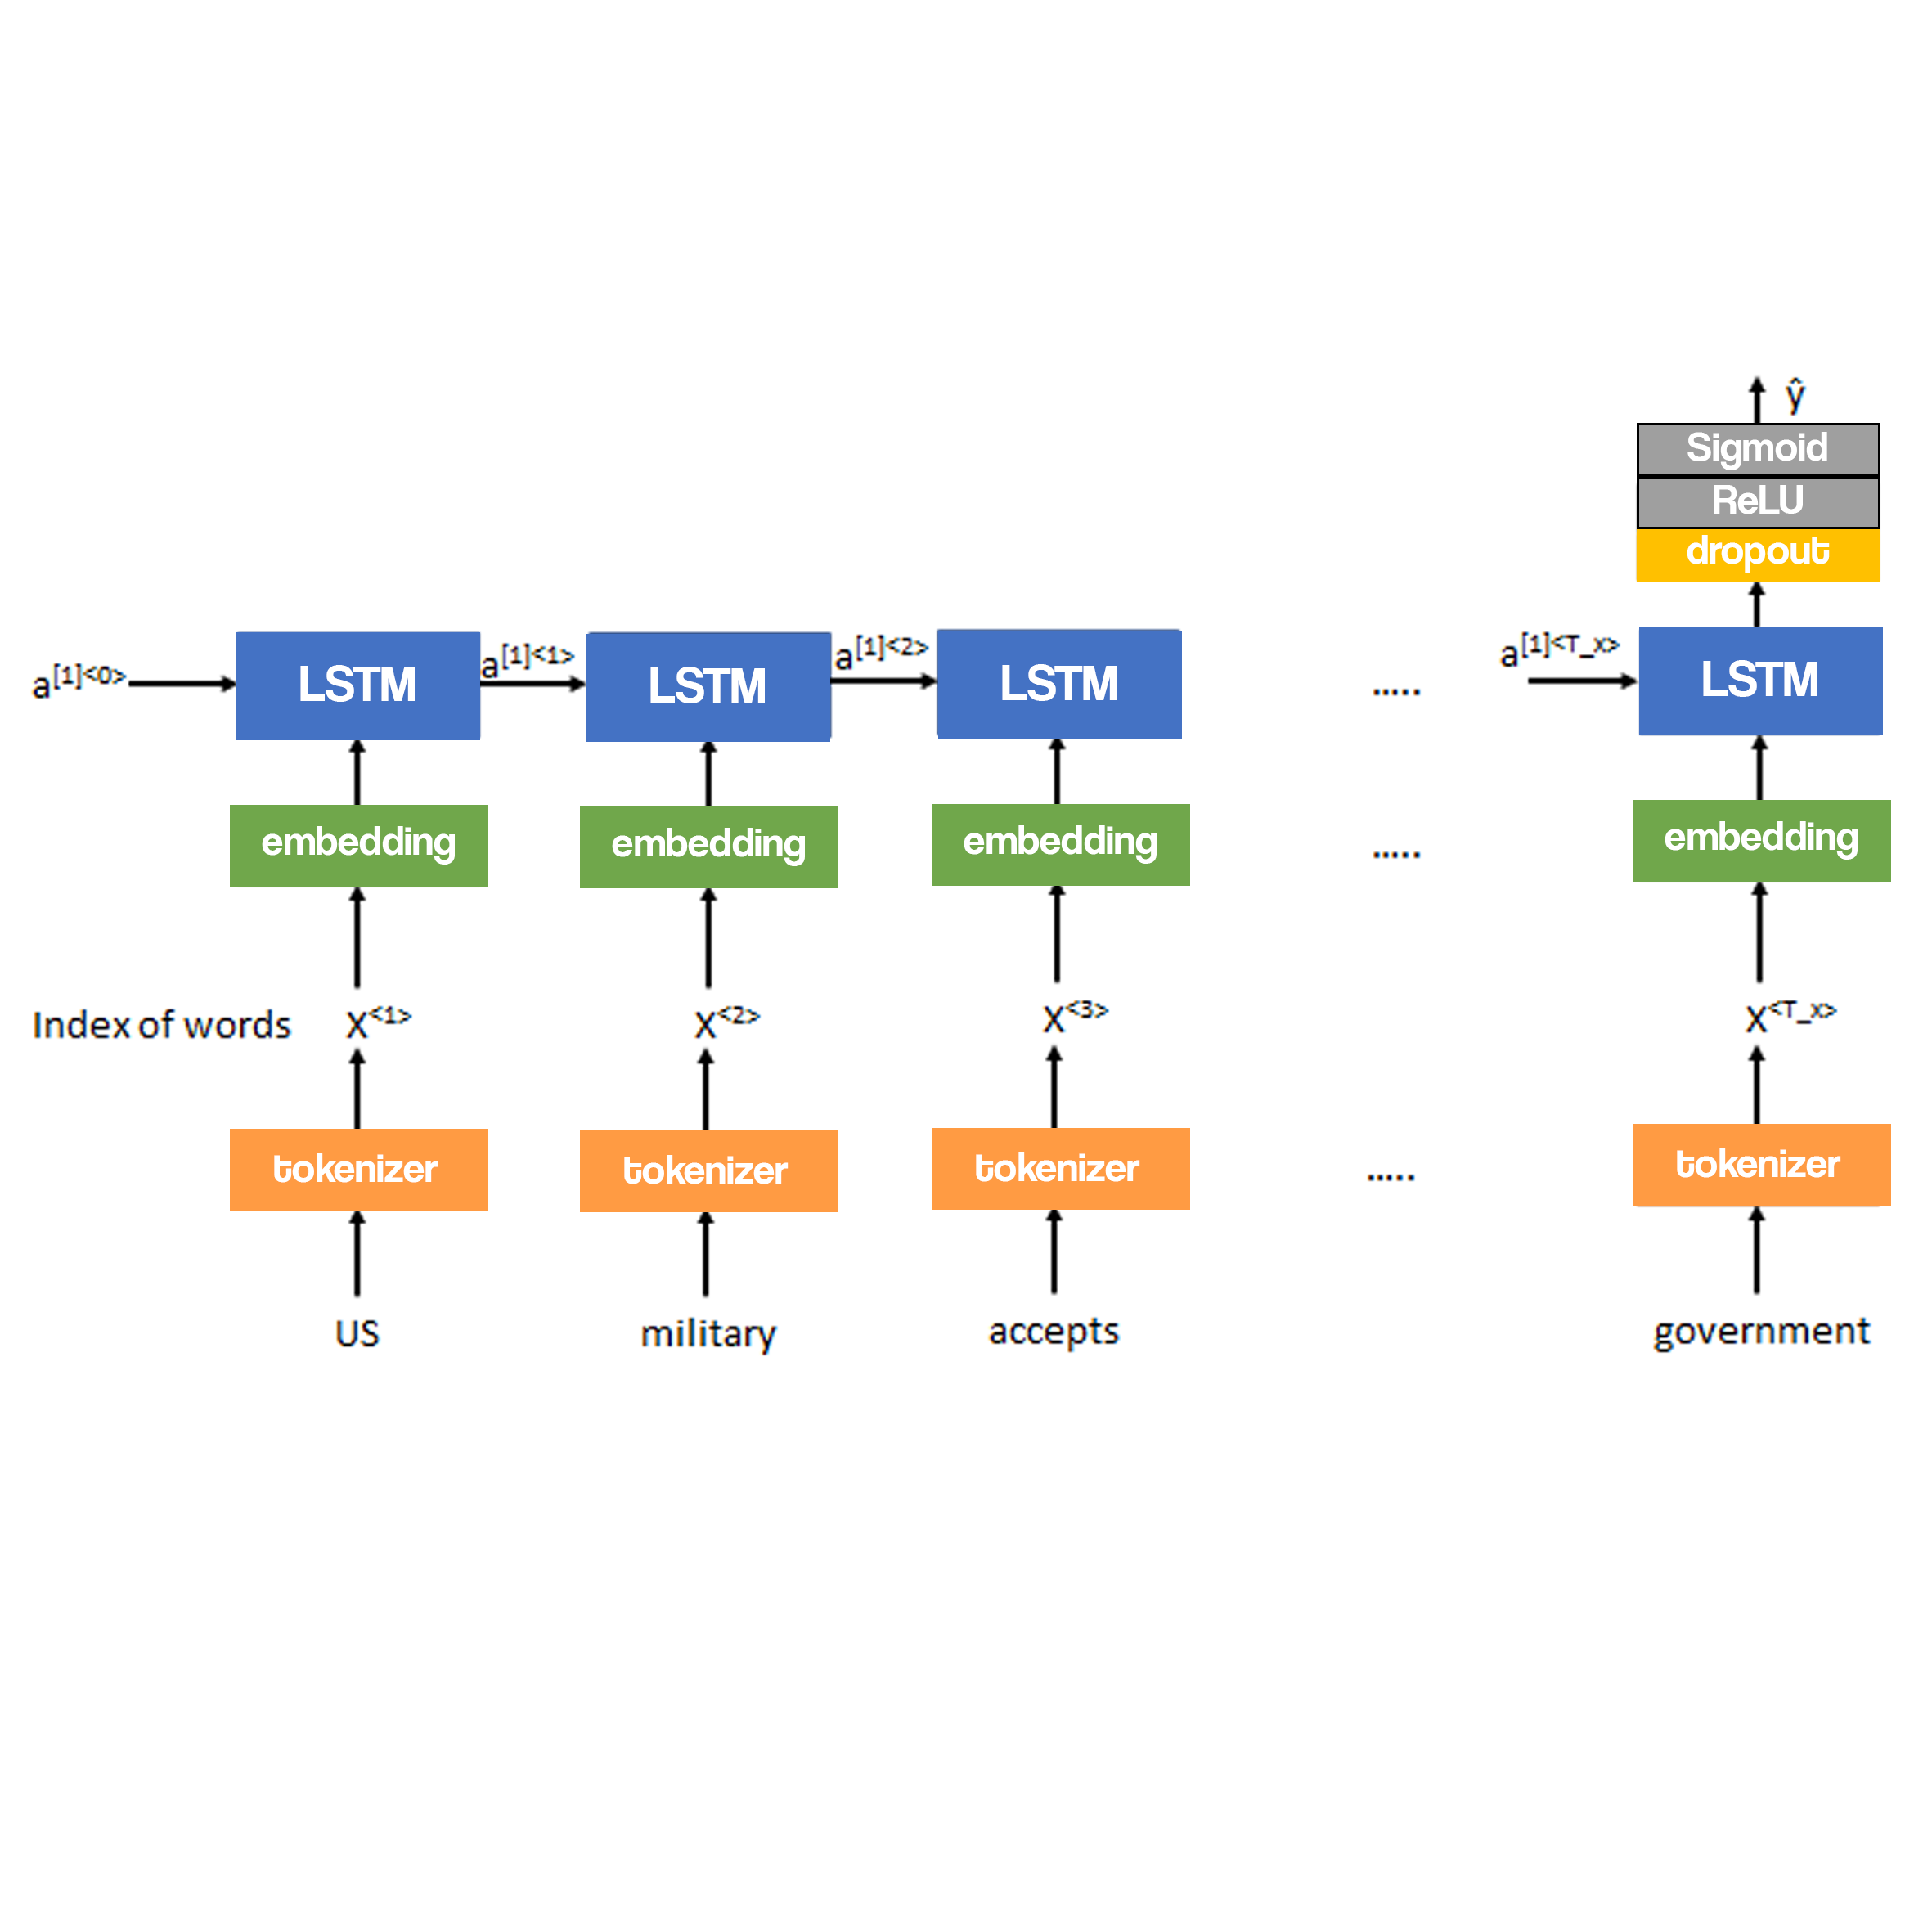

**First Layer: Embedding Layer**

It represents words using a dense vector representation. The position of a word within the vector space is based on the words that surround the word when it is used. E.g “king” is placed near “man”

In this case, we set the `weights` of the Embedding layer with embedding matrix from GloVe pre-trained vectors <br>We set the parameter `trainable` to False as we don't want the embedding weights to be updated

**Second Layer: LSTM**

Here we will use 3 different unit sizes, whicha re 64, 128, and 256. 
<br>The `return_sequences` set to be False as we don't want the output of previous LSTM layers to be used as the input in the next LSTM layers



**Third Layer: Dropout**

It is a regularizer technique that keeping it as away as possible from any bias (overfitting) by dropping out neurons at random, during every epoch
<br>Fraction of the input `unit` to drop: 0.5

**Final Layer: Dense**

It helps in changing the dimensionality of the output from the preceding layer so that the model can easily define the relationship between the values of the data in which the model is working.

We first use the ReLU (Rectified Linear Unit) activation function. The function returns 0 if it receives any negative input, but for any positive value  x  it returns that value back. So it can be written as  f(x)=max(0,x). The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

Since we are doing a Binary Classification in this case, the `activation` function is **sigmoid(x) = 1 / (1 + exp(-x))**. <br>Sigmoid function maps any input to an output ranging from **0 to 1** 
Sigmoid layer `unit` equals to 1 as the output size of the final layer


##### **LSTM with output size of 64**

In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Fit the model to the training and testing dataset

In [ ]:
epochs  = 20
history = lstm_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

Evaluation of LSTM Model

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()


In [ ]:
train_lstm_results = lstm_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

In [ ]:
preds = lstm_model.predict(X_test_pad)

preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]

cm = confusion_matrix(preds_np, y_test)

sns.heatmap(cm, annot = True)

##### **LSTM with output size of 128**

In [ ]:
lstm2_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(128,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm2_model.summary())

In [ ]:
epochs  = 20
history = lstm2_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()

In [ ]:
train_lstm2_results = lstm2_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm2_results = lstm2_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm2_results[1]*100:0.3f}')
print(f'Test accuracy: {test_lstm2_results[1]*100:0.3f}')

In [ ]:
preds = lstm2_model.predict(X_test_pad)
preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]

cm = confusion_matrix(preds_np, y_test)

sns.heatmap(cm, annot = True)

##### **LSTM with output size of 256**

In [ ]:
lstm3_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(256,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm3_model.summary())

In [ ]:
epochs  = 20
history = lstm3_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()


In [ ]:
train_lstm3_results = lstm2_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm3_results = lstm2_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm3_results[1]*100:0.3f}')
print(f'Test accuracy: {test_lstm3_results[1]*100:0.3f}')

In [ ]:
preds = lstm3_model.predict(X_test_pad)
preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]
cm = confusion_matrix(preds_np, y_test)
sns.heatmap(cm, annot = True)
